# Unit 6. From Text to Speech

## Pre-trained models for text-to-speech

### SpeechT5

In [ ]:
# accelerate>=0.20.1 needed for the Trainer
!pip install accelerate -U
# SentencePiece needed for SpeechT5
!pip install sentencepiece

# Need to restart Runtime after running this cell

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 4.7 MB/s eta 0:00:00


In [ ]:
# Install the latest version (not on PyPi at that time)
!pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-xxg6xrk2
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-xxg6xrk2
  Resolved https://github.com/huggingface/transformers to commit cb8e3ee25fc2349e9262faa1e0c35d80978349fe
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# Load pre-trained model with its processor
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech

processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")

In [ ]:
# Tokenize the input text
inputs = processor(text="Don't count the days, make the days count.",
                   return_tensors="pt")

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.9 MB/s eta 0:00:00


In [ ]:
# Load a X-vectors embedding
from datasets import load_dataset

embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors",
                                  split="validation")

import torch

speaker_embeddings = torch.tensor(embeddings_dataset[7306]["xvector"]).unsqueeze(0)

Generating validation split: 0 examples [00:00, ? examples/s]

In [ ]:
speaker_embeddings.shape

torch.Size([1, 512])

In [ ]:
# Generate a log-mel spectrogram
spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)

In [ ]:
# First dimension is the sequence length
# Second is the number of bins
spectrogram.shape

torch.Size([138, 80])

In [ ]:
# Load the vocoder to convert the spectrogram to waveform
from transformers import SpeechT5HifiGan

vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

In [ ]:
# Add it as an argument in the model
speech = model.generate_speech(inputs["input_ids"], speaker_embeddings,
                               vocoder=vocoder)

In [ ]:
# Listen to the result
from IPython.display import Audio

Audio(speech, rate=16000)

### Massive Multilingual Speech (MMS)

In [ ]:
# Need to run this fork as model is not yet available
!pip install git+https://github.com/hollance/transformers.git@6900e8ba6532162a8613d2270ec2286c3f58f57b

  Cloning https://github.com/hollance/transformers.git (to revision 6900e8ba6532162a8613d2270ec2286c3f58f57b) to /tmp/pip-req-build-ekq2w66i
  Running command git clone --filter=blob:none --quiet https://github.com/hollance/transformers.git /tmp/pip-req-build-ekq2w66i
  Running command git rev-parse -q --verify 'sha^6900e8ba6532162a8613d2270ec2286c3f58f57b'
  Running command git fetch -q https://github.com/hollance/transformers.git 6900e8ba6532162a8613d2270ec2286c3f58f57b
  Running command git checkout -q 6900e8ba6532162a8613d2270ec2286c3f58f57b
  Resolved https://github.com/hollance/transformers.git to commit 6900e8ba6532162a8613d2270ec2286c3f58f57b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.31.0.dev0-py3-none-any.whl size=7253493 sha256=64f41e89fed9b531060640f48faabc1a9157b7443abb3595c16b7d8593e27a7a
  Stored in directory: /root/.cache/

In [ ]:
# Load the model
from transformers import VitsModel, VitsTokenizer

model = VitsModel.from_pretrained("Matthijs/mms-tts-deu")
tokenizer = VitsTokenizer.from_pretrained("Matthijs/mms-tts-deu")

In [ ]:
# Define an example in German
text_example = (
    "Ich bin Schnappi das kleine Krokodil, komm aus Ägypten das liegt direkt am Nil."
)

In [ ]:
# Preprocess, then pass to the model
import torch

inputs = tokenizer(text_example, return_tensors="pt")
input_ids = inputs["input_ids"]


with torch.no_grad():
    outputs = model(input_ids)

speech = outputs.audio[0]

In [ ]:
# Listen to the output
from IPython.display import Audio

Audio(speech, rate=16000)

## Fine-tuning SpeechT5

In [ ]:
# Install dependencies
!pip install transformers datasets soundfile speechbrain accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.8/553.8 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 7.9 MB/s eta 0:00:00


In [ ]:
# Log to the Hub
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
# Load the data (only 50% here)
from datasets import load_dataset, Audio

dataset = load_dataset("facebook/voxpopuli", "nl", split="train[:50%]")
len(dataset)

10484

In [ ]:
# Resample to match the expected 16kHz
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

In [ ]:
# Load the processor assiociated to the checkpoint
from transformers import SpeechT5Processor

checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)

In [ ]:
# Retrieve the tokenizer
tokenizer = processor.tokenizer

In [ ]:
# Look at one example
dataset[0]

{'audio_id': '20100210-0900-PLENARY-3-nl_20100210-09:06:43_4',
 'language': 9,
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/02ec6a19d5b97c03e1379250378454dbf3fa2972943504a91c7da5045aa26a89/train_part_0/20100210-0900-PLENARY-3-nl_20100210-09:06:43_4.wav',
  'array': array([ 4.27246094e-04,  1.31225586e-03,  1.03759766e-03, ...,
         -9.15527344e-05,  7.62939453e-04, -2.44140625e-04]),
  'sampling_rate': 16000},
 'raw_text': 'Dat kan naar mijn gevoel alleen met een brede meerderheid die wij samen zoeken.',
 'normalized_text': 'dat kan naar mijn gevoel alleen met een brede meerderheid die wij samen zoeken.',
 'gender': 'female',
 'speaker_id': '1122',
 'is_gold_transcript': True,
 'accent': 'None'}

In [ ]:
# Use "normalized_text" and not "raw_text" because numbers are written in the
# normalized version, and SpeechT5 tokenizer doesn't have any token for numbers
# Define a function to extract the characters, then apply
def extract_all_chars(batch):
    all_text = " ".join(batch["normalized_text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}


vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}

Map:   0%|          | 0/10484 [00:00<?, ? examples/s]

In [ ]:
# Substract to see which character are not recognized by SpeechT5 tokenizer
dataset_vocab - tokenizer_vocab

{' ', 'à', 'è', 'ë', 'í', 'ï', 'ö', 'ü'}

In [ ]:
# Replace these characters by their supported version
replacements = [
    ("à", "a"),
#    ("ç", "c"),
    ("è", "e"),
    ("ë", "e"),
    ("í", "i"),
    ("ï", "i"),
    ("ö", "o"),
    ("ü", "u"),
]


def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["normalized_text"] = inputs["normalized_text"].replace(src, dst)
    return inputs


dataset = dataset.map(cleanup_text)

Map:   0%|          | 0/10484 [00:00<?, ? examples/s]

In [ ]:
# Count the numbe of speakers
from collections import defaultdict

speaker_counts = defaultdict(int)

for speaker_id in dataset["speaker_id"]:
    speaker_counts[speaker_id] += 1

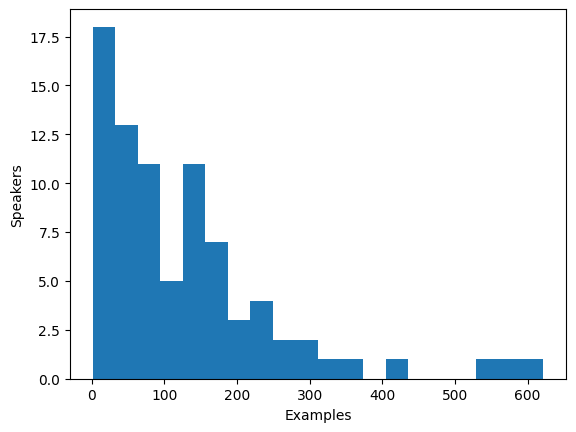

In [ ]:
# Plot how much data there is for each speaker
import matplotlib.pyplot as plt

plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

In [ ]:
# Limit the data to speakers with between 100 and 400 examples
def select_speaker(speaker_id):
    return 100 <= speaker_counts[speaker_id] <= 400


dataset = dataset.filter(select_speaker, input_columns=["speaker_id"])

Filter:   0%|          | 0/10484 [00:00<?, ? examples/s]

In [ ]:
# Check how many remain
len(set(dataset["speaker_id"]))

36

In [ ]:
# Check how many examples are left
len(dataset)

6618

In [ ]:
# Create a speaker embedding for each example
import os
import torch
from speechbrain.pretrained import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name),
)


def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings,
                                                           dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

In [ ]:
# Preprocess the data
def prepare_dataset(example):
    audio = example["audio"]

    example = processor(
        text=example["normalized_text"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example


# Check that it is correct
processed_example = prepare_dataset(dataset[0])
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

In [ ]:
# Speaker embeddings should be a 512-elements vector
processed_example["speaker_embeddings"].shape

(512,)

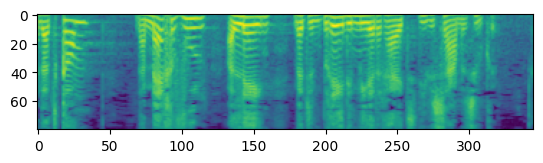

In [ ]:
# The labels should be a log-mel spectrogram with 80 bins
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

In [ ]:
# Now apply the preprocessing to the dataset
dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names)

Map:   0%|          | 0/6618 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (723 > 600). Running this sequence through the model will result in indexing errors


In [ ]:
# Create a function to remove anything over 200 tokens
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200


dataset = dataset.filter(is_not_too_long, input_columns=["input_ids"])
len(dataset)

Filter:   0%|          | 0/6618 [00:00<?, ? examples/s]

5612

In [ ]:
# Create a basic train test split
dataset = dataset.train_test_split(test_size=0.1)

In [ ]:
# Define the data collator
from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        input_ids = [
            {"input_ids": feature["input_ids"]} for feature in features]
        label_features = [
            {"input_values": feature["labels"]} for feature in features]
        speaker_features = [
            feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids, labels=label_features, return_tensors="pt"
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor(
                [len(feature["input_values"]) for feature in label_features]
            )
            target_lengths = target_lengths.new(
                [
                    length - length % model.config.reduction_factor
                    for length in target_lengths
                ]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In [ ]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

In [ ]:
# Load the pre-trained model
from transformers import SpeechT5ForTextToSpeech

model = SpeechT5ForTextToSpeech.from_pretrained(checkpoint)

In [ ]:
# Adjust parameters
from functools import partial

# disable cache during training since it's incompatible with gradient checkpointing
model.config.use_cache = False

# set language and task for generation and re-enable cache
model.generate = partial(model.generate, use_cache=True)

In [ ]:
# Define the training arguments
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="speecht5_finetuned_voxpopuli_nl", # Can be changed
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=2000,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=2,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=True,
)

In [ ]:
# Instantiate the trainer
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor,
)

Cloning https://huggingface.co/64FC/speecht5_finetuned_voxpopuli_nl into local empty directory.


In [ ]:
# Run
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,0.520700,0.478247
2000,0.504300,0.470311


TrainOutput(global_step=2000, training_loss=0.5540691823959351, metrics={'train_runtime': 3878.7735, 'train_samples_per_second': 16.5, 'train_steps_per_second': 0.516, 'total_flos': 8478013783516992.0, 'train_loss': 0.5540691823959351, 'epoch': 12.67})

In [ ]:
# Then push to the Hub
trainer.push_to_hub()

To https://huggingface.co/64FC/speecht5_finetuned_voxpopuli_nl
   05f4ff4..7143c38  main -> main

   05f4ff4..7143c38  main -> main

To https://huggingface.co/64FC/speecht5_finetuned_voxpopuli_nl
   7143c38..19dc824  main -> main

   7143c38..19dc824  main -> main



'https://huggingface.co/64FC/speecht5_finetuned_voxpopuli_nl/commit/7143c388066a1b9c4eff747d4919348659afdd1a'

In [ ]:
# Load the (newly trained) model for inference
model = SpeechT5ForTextToSpeech.from_pretrained(
    "64FC/speecht5_finetuned_voxpopuli_nl"
)

In [ ]:
# Pick an example
example = dataset["test"][304]
speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0)

In [ ]:
# Define some input text
text = "hallo allemaal, ik praat nederlands. groetjes aan iedereen!"

# Preprocess it
inputs = processor(text=text, return_tensors="pt")

In [ ]:
# Instantiate a vocoder and generate speech
from transformers import SpeechT5HifiGan

vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")
speech = model.generate_speech(inputs["input_ids"], speaker_embeddings,
                               vocoder=vocoder)

In [ ]:
# Listen to the result
from IPython.display import Audio

Audio(speech.numpy(), rate=16000)

## Hands-on exercise

In [1]:
# accelerate>=0.20.1 needed for the Trainer
!pip install accelerate -U
# SentencePiece needed for SpeechT5
!pip install sentencepiece

# Need to restart Runtime after running this cell

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.7 MB/s eta 0:00:00


In [1]:
!pip install transformers datasets soundfile speechbrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.8/553.8 kB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 89.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 48.5 MB/s eta 0:00:00


In [2]:
# Link notebook to the Hub
from huggingface_hub import notebook_login

notebook_login()

In [3]:
# Load the Italian subset of Voxpopuli
from datasets import load_dataset, Audio

dataset = load_dataset("facebook/voxpopuli", "it", split="train")
len(dataset)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

22576

In [5]:
dataset[0]

{'audio_id': '20130522-0900-PLENARY-15-it_20130522-17:29:48_2',
 'language': 5,
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/59d3156fa3afac96252c828faab59a4711c54e196e66b8774c057b01f58e999d/train_part_0/20130522-0900-PLENARY-15-it_20130522-17:29:48_2.wav',
  'array': array([0.04092407, 0.03231812, 0.037323  , ..., 0.00527954, 0.00784302,
         0.00302124]),
  'sampling_rate': 16000},
 'raw_text': "Ma quanto sarebbe utile che, recuperando i patrimoni sottratti da dittatori e da nomenclature, si creino dei fondi di sviluppo economico diffuso, del microcredito, delle agevolazioni per l'imprenditoria, delle borse di studio per gli studenti, e sarebbe il modo migliore per restituire ai cittadini quanto gli è stato sottratto e si darebbe un segnale potente di che cosa può offrire una collaborazione internazionale virtuosa.",
 'normalized_text': "ma quanto sarebbe utile che recuperando i patrimoni sottratti da dittatori e da nomenclature si creino dei fondi di 

In [ ]:
# Resample to match the expected 16kHz
# Not needed here as it is already 16kHz
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

In [12]:
# Selecting a subset for training
dataset_split = dataset.train_test_split(seed=23, shuffle=True, train_size=0.5)
dataset_split

DatasetDict({
    train: Dataset({
        features: ['audio_id', 'language', 'audio', 'raw_text', 'normalized_text', 'gender', 'speaker_id', 'is_gold_transcript', 'accent'],
        num_rows: 11288
    })
    test: Dataset({
        features: ['audio_id', 'language', 'audio', 'raw_text', 'normalized_text', 'gender', 'speaker_id', 'is_gold_transcript', 'accent'],
        num_rows: 11288
    })
})

In [13]:
dataset_small = dataset_split["train"]

In [7]:
# Load the processor assiociated to the checkpoint
from transformers import SpeechT5Processor

checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)

In [8]:
# Retrieve the tokenizer
tokenizer = processor.tokenizer

In [14]:
# Use "normalized_text" and not "raw_text" because numbers are written in the
# normalized version, and SpeechT5 tokenizer doesn't have any token for numbers
# Define a function to extract the characters, then apply
def extract_all_chars(batch):
    all_text = " ".join(batch["normalized_text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}


vocabs = dataset_small.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset_small.column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}

Map:   0%|          | 0/11288 [00:00<?, ? examples/s]

In [15]:
# Substract to see which character are not recognized by SpeechT5 tokenizer
dataset_vocab - tokenizer_vocab

{' ', 'à', 'è', 'ì', 'í', 'ï', 'ò', 'ó', 'ù'}

In [16]:
# Replace these characters by their supported version
# (add values in case not in the sample)
replacements = [
    ("à", "a"),
    ("ç", "c"),
    ("è", "e"),
    ("ë", "e"),
    ("ì", "i"),
    ("í", "i"),
    ("ï", "i"),
    ("ò", "o"),
    ("ó", "o"),
    ("ö", "o"),
    ("ù", "u"),
    ("ü", "u"),
]


def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["normalized_text"] = inputs["normalized_text"].replace(src, dst)
    return inputs


dataset_small = dataset_small.map(cleanup_text)

Map:   0%|          | 0/11288 [00:00<?, ? examples/s]

In [17]:
# Count the numbe of speakers
from collections import defaultdict

speaker_counts = defaultdict(int)

for speaker_id in dataset_small["speaker_id"]:
    speaker_counts[speaker_id] += 1

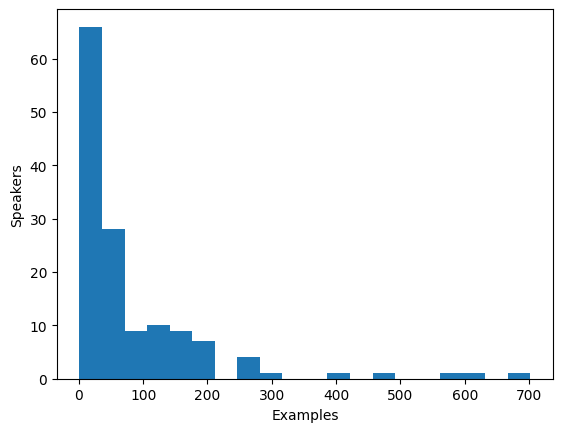

In [18]:
# Plot how much data there is for each speaker
import matplotlib.pyplot as plt

plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

In [19]:
# Limit the data to speakers with between 50 and 300 examples
def select_speaker(speaker_id):
    return 50 <= speaker_counts[speaker_id] <= 300


dataset_small = dataset_small.filter(select_speaker,
                                     input_columns=["speaker_id"])

Filter:   0%|          | 0/11288 [00:00<?, ? examples/s]

In [20]:
# Check how many remain
len(set(dataset_small["speaker_id"]))

56

In [21]:
# Check how many examples are left
len(dataset_small)

7184

In [22]:
# Create a speaker embedding for each example
import os
import torch
from speechbrain.pretrained import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name),
)


def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings,
                                                           dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

In [23]:
# Preprocess the data
def prepare_dataset(example):
    audio = example["audio"]

    example = processor(
        text=example["normalized_text"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example


# Check that it is correct
processed_example = prepare_dataset(dataset_small[0])
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

In [24]:
# Speaker embeddings should be a 512-elements vector
processed_example["speaker_embeddings"].shape

(512,)

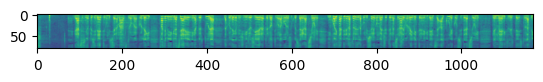

In [25]:
# The labels should be a log-mel spectrogram with 80 bins
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

In [26]:
# Now apply the preprocessing to the dataset
dataset_small = dataset_small.map(prepare_dataset,
                                  remove_columns=dataset_small.column_names)

Map:   0%|          | 0/7184 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (752 > 600). Running this sequence through the model will result in indexing errors


In [27]:
# Create a function to remove anything over 250 tokens
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 250


dataset_small = dataset_small.filter(is_not_too_long,
                                     input_columns=["input_ids"])
len(dataset_small)

Filter:   0%|          | 0/7184 [00:00<?, ? examples/s]

4910

In [28]:
# Create a basic train test split
dataset_small = dataset_small.train_test_split(test_size=0.1)

In [30]:
# Define the data collator
from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        input_ids = [
            {"input_ids": feature["input_ids"]} for feature in features]
        label_features = [
            {"input_values": feature["labels"]} for feature in features]
        speaker_features = [
            feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids, labels=label_features, return_tensors="pt"
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor(
                [len(feature["input_values"]) for feature in label_features]
            )
            target_lengths = target_lengths.new(
                [
                    length - length % model.config.reduction_factor
                    for length in target_lengths
                ]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch


data_collator = TTSDataCollatorWithPadding(processor=processor)

In [31]:
# Load the pre-trained model
from transformers import SpeechT5ForTextToSpeech

model = SpeechT5ForTextToSpeech.from_pretrained(checkpoint)

In [32]:
# Adjust parameters
from functools import partial

# disable cache during training since it's incompatible
# with gradient checkpointing
model.config.use_cache = False

# set language and task for generation and re-enable cache
model.generate = partial(model.generate, use_cache=True)

In [33]:
# Define the training arguments
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="speecht5_finetuned_voxpopuli_it",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=2500,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=2,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=True,
)

In [34]:
# Instantiate the trainer
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset_small["train"],
    eval_dataset=dataset_small["test"],
    data_collator=data_collator,
    tokenizer=processor,
)

In [35]:
# Run
trainer.train()

Step,Training Loss,Validation Loss
1000,0.535600,0.500679
2000,0.519600,0.489899


TrainOutput(global_step=2500, training_loss=0.558836400604248, metrics={'train_runtime': 5882.7196, 'train_samples_per_second': 13.599, 'train_steps_per_second': 0.425, 'total_flos': 1.4011877072376216e+16, 'train_loss': 0.558836400604248, 'epoch': 18.1})

In [36]:
# Define the kwargs
kwargs = {
    "dataset_tags": "facebook/voxpopuli",
    "dataset": "VoxPopuli",
    "finetuned_from": "microsoft/speecht5_tts",
    "tasks": "text-to-speech",
}

# Then push to the Hub
trainer.push_to_hub(**kwargs)

'https://huggingface.co/64FC/speecht5_finetuned_voxpopuli_it/tree/main/'